# Code Quality Correlations

Correlation:
- join with objectives score
- compute length
- compute inv_inf score

Comparison
- direct/indirect

In [1]:
import sqlite3
import pandas as pd
import os

db_path = "../../giicg.db"
if not os.path.exists(db_path):
    raise FileNotFoundError(f"Database file does not exist: {db_path}")

conn = sqlite3.connect(db_path)
code = pd.read_sql("""
    SELECT ps.conversation_id, ps. message_id, ps.message_text, ps.gender, ps.user_id, ps.model_version,  ps.radon_complexity,ps.radon_maintainability_index, ps.radon_loc, ps.radon_sloc, ps.radon_lloc, ps.radon_comments, ps.pylint_score,
           ap.maj_objectives_score, ap.maj_communication_score,
           p.conversational,
           cp.can_you_question, cp.i_statement, cp.unpersonal_command, cp.you_command, cp.we_command, cp.unpersonal_question, cp.i_question, cp.we_question,
        iis.involved, iis.informational, iis.inv_inf,
        llmj.code, llmj.reasoning, llmj.validity_score, llmj.cleanliness_score, llmj.readability_score, llmj.structure_score, llmj.best_practices_score
    FROM pylint_scores ps
    JOIN annotated_prompts ap ON ps.message_id = ap.message_id
    JOIN manually_split_prompts p ON ps.message_id = p.message_id
    JOIN categorized_prompts cp ON ps.message_id = cp.message_id
    JOIN inv_inf_scores iis ON ps.message_id = iis.message_id
    JOIN llm_judge_COT_gpt5 llmj ON ps.code_reply_id = llmj.code_reply_id;
""", conn)

cols_to_int = [
    "validity_score",
    "cleanliness_score",
    "readability_score",
    "structure_score",
    "best_practices_score"
]

# Coerce errors to NaN if conversion fails, then optionally fillna or handle them as you wish
for col in cols_to_int:
    code[col] = pd.to_numeric(code[col], errors='coerce').astype('Int64')


code

,conversation_id,message_id,message_text,gender,user_id,model_version,radon_complexity,radon_maintainability_index,radon_loc,radon_sloc,...,involved,informational,inv_inf,code,reasoning,validity_score,cleanliness_score,readability_score,structure_score,best_practices_score
0,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,chatgpt-4o-latest,0.000000,100.000000,19.0,8.0,...,18.181818,18.181818,1.000000,from sklearn.preprocessing import OneHotEncode...,1. The code runs without errors and uses defin...,10,9,9,9,9
1,8,47,I have a pandas dataframe like this:\ndata\tpe...,Woman (cisgender),28,chatgpt-4o-latest,0.000000,100.000000,22.0,9.0,...,29.411765,14.705882,2.000000,import pandas as pd\n\n# Assuming your DataFra...,1. The code is valid and should run without er...,9,8,7,7,8
2,10,57,"as a NLP and LLM researcher, I am recently dow...",Non-binary,30,chatgpt-4o-latest,NaN,NaN,36.0,32.0,...,16.304348,19.565217,0.833333,import os\n import requests\n import time\...,1. The code should run without errors if the G...,8,7,7,7,7
3,12,65,Blender and Python. I have a collection of hun...,Man (cisgender),34,chatgpt-4o-latest,6.000000,76.810412,62.0,38.0,...,15.384615,20.512821,0.750000,import bpy\nimport mathutils\n\n# === CONFIGUR...,1. Validity: The code appears to be valid and ...,9,9,8,9,9
4,13,126,"how to run a Python future without blocking, i...",Man (cisgender),46,chatgpt-4o-latest,1.333333,90.912037,21.0,16.0,...,15.151515,18.181818,0.833333,import asyncio\n\nasync def my_coro():\n pr...,"1. The code compiles and runs without errors, ...",10,9,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,70,1524,can you write a test that tests whether parse ...,Woman (cisgender),90,deepseek-chat,5.000000,87.789161,30.0,22.0,...,25.000000,16.666667,1.500000,import pytest\nfrom pydantic import Validation...,1. The code appears to be valid as it uses def...,9,9,9,9,9
491,72,1534,can you write me some python code to count the...,Woman (cisgender),11,deepseek-chat,1.000000,82.315095,25.0,17.0,...,18.750000,18.750000,1.000000,import json\n\ndef count_objects_in_json(data)...,"1. The code compiles and runs without errors, ...",10,9,9,9,9
492,74,1538,I want to merge these two dataframes: \ndf_tra...,Woman (cisgender),28,deepseek-chat,0.000000,100.000000,1.0,1.0,...,16.666667,27.777778,0.600000,merged_df = df_train_claim.merge(df_train_clai...,1. The code uses the `merge` function from pan...,9,9,9,7,9
493,78,1598,"0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,...",Woman (cisgender),73,deepseek-chat,0.000000,100.000000,21.0,14.0,...,16.666667,20.000000,0.833333,from sklearn.cluster import KMeans\nfrom sklea...,1. The code is missing the definition of `prep...,4,6,5,5,6


In [2]:
import pandas as pd

# List of columns to aggregate using mean and std
agg_cols = [
    "radon_complexity",
    "radon_maintainability_index",
    "radon_loc",
    "radon_sloc",
    "radon_lloc",
    "radon_comments",
    "pylint_score",
    "validity_score",
    "cleanliness_score",
    "readability_score",
    "structure_score",
    "best_practices_score"
]

# Define aggregation dictionary for mean and std, ignore NaNs automatically
agg_dict = {}
for col in agg_cols:
    agg_dict[col] = ['mean', 'std']

# Group by the required columns
group_cols = [
    "conversation_id",
    "message_id",
    "message_text",
    "conversational",
    "gender",
    "user_id",
    "model_version",
    "maj_objectives_score",
    "maj_communication_score",
    "can_you_question",
    "i_statement",
    "unpersonal_command",
    "you_command",
    "we_command",
    "unpersonal_question",
    "i_question",
    "we_question",
    "informational",
    "involved",
    "inv_inf"
]

# Perform aggregation
agg_df = (
    code
    .groupby(group_cols, dropna=False)
    .agg(agg_dict)
    .reset_index()
)

# Flatten column multi-index
agg_df.columns = [
    f"{col if stat == '' else stat + '_' + col}" if stat != '' else col
    for col, stat in agg_df.columns.to_flat_index()
]

# Move mean_/std_ to correct suffix format: mean_colname, std_colname
agg_df = agg_df.rename(columns={f"mean_{col}": f"mean_{col}" for col in agg_cols})
agg_df = agg_df.rename(columns={f"std_{col}": f"std_{col}" for col in agg_cols})

agg_df


,conversation_id,message_id,message_text,conversational,gender,user_id,model_version,maj_objectives_score,maj_communication_score,can_you_question,...,mean_validity_score,std_validity_score,mean_cleanliness_score,std_cleanliness_score,mean_readability_score,std_readability_score,mean_structure_score,std_structure_score,mean_best_practices_score,std_best_practices_score
0,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,chatgpt-4o-latest,5,6,0,...,10.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0
1,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,claude-3-7-sonnet-20250219,5,6,0,...,9.0,0.0,8.666667,0.57735,9.0,0.0,9.0,0.0,9.0,0.0
2,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,claude-sonnet-4-20250514,5,6,0,...,8.333333,1.154701,8.666667,0.57735,8.666667,0.57735,8.666667,0.57735,8.333333,1.154701
3,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,deepseek-chat,5,6,0,...,9.0,0.0,9.0,0.0,8.666667,0.57735,8.666667,0.57735,9.0,0.0
4,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,gpt-4.1-2025-04-14,5,6,0,...,10.0,0.0,9.0,0.0,9.0,0.0,8.666667,0.57735,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,claude-sonnet-4-20250514,3,5,0,...,8.666667,0.57735,9.0,0.0,9.0,0.0,8.666667,0.57735,9.0,0.0
163,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,deepseek-chat,3,5,0,...,6.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0
164,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,gpt-4.1-2025-04-14,3,5,0,...,6.666667,2.516611,8.0,1.732051,7.666667,1.527525,7.666667,1.527525,7.333333,2.081666
165,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,gpt-5-chat-latest,3,5,0,...,7.0,1.732051,8.333333,0.57735,8.333333,0.57735,8.333333,0.57735,8.666667,0.57735


In [3]:
agg_df["length_message_text_chars"] = agg_df["message_text"].astype(str).apply(len)
agg_df["length_conversational_chars"] = agg_df["conversational"].astype(str).apply(len)

# Word count
agg_df["length_message_text_words"] = agg_df["message_text"].astype(str).apply(lambda x: len(x.split()))
agg_df["length_conversational_words"] = agg_df["conversational"].astype(str).apply(lambda x: len(x.split()))


## Exlude two prompts
exclude 1524 because it contains code
exlcude 764 because it asks the model to something that is bad practice

In [4]:
agg_df = agg_df[agg_df["message_id"] != 1524]
agg_df = agg_df[agg_df["message_id"] != 764]
agg_df

,conversation_id,message_id,message_text,conversational,gender,user_id,model_version,maj_objectives_score,maj_communication_score,can_you_question,...,mean_readability_score,std_readability_score,mean_structure_score,std_structure_score,mean_best_practices_score,std_best_practices_score,length_message_text_chars,length_conversational_chars,length_message_text_words,length_conversational_words
0,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,chatgpt-4o-latest,5,6,0,...,9.0,0.0,9.0,0.0,9.0,0.0,191,191,36,36
1,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,claude-3-7-sonnet-20250219,5,6,0,...,9.0,0.0,9.0,0.0,9.0,0.0,191,191,36,36
2,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,claude-sonnet-4-20250514,5,6,0,...,8.666667,0.57735,8.666667,0.57735,8.333333,1.154701,191,191,36,36
3,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,deepseek-chat,5,6,0,...,8.666667,0.57735,8.666667,0.57735,9.0,0.0,191,191,36,36
4,6,5,I want to use Dummy Hot encoding to replace th...,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,gpt-4.1-2025-04-14,5,6,0,...,9.0,0.0,8.666667,0.57735,9.0,0.0,191,191,36,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,claude-sonnet-4-20250514,3,5,0,...,9.0,0.0,8.666667,0.57735,9.0,0.0,57,79,10,12
163,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,deepseek-chat,3,5,0,...,8.0,0.0,8.0,0.0,8.0,0.0,57,79,10,12
164,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,gpt-4.1-2025-04-14,3,5,0,...,7.666667,1.527525,7.666667,1.527525,7.333333,2.081666,57,79,10,12
165,86,1664,how to merge multiple xarray under a new categ...,wie kann man mehrere xarray unter einer neuen ...,Woman (cisgender),60,gpt-5-chat-latest,3,5,0,...,8.333333,0.57735,8.333333,0.57735,8.666667,0.57735,57,79,10,12


In [5]:
models = ["chatgpt-4o-latest", "o3-2025-04-16", "gpt-5-chat-latest", "gpt-4.1-2025-04-14", "deepseek-chat", "claude-3-7-sonnet-20250219", "claude-sonnet-4-20250514"]

## plot pylint codes


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_model_distributions(
        agg_df,
        models,
        column,
        n_cols=3,
        bins=20,
        xlim=None,
        kde=None,         # <-- Explicit 'kde' parameter configures plot type
        title=None,
        hist_kwargs=None,
        kde_kwargs=None
):
    """
    Plot a distribution (histogram or KDE) of a selected column for each model.

    Parameters:
        agg_df: DataFrame
        models: list of str, model names
        column: str, name of the column to plot
        n_cols: number of subplot columns
        bins: bins for histogram
        xlim: tuple or None
        kde: bool or None
             True  = always plot density (KDE)
             False = always plot histogram
             None  = auto-detect by data properties (continuous => KDE, integer/small-unique => hist)
        title: str
        hist_kwargs: dict, passed to sns.histplot
        kde_kwargs: dict, passed to sns.kdeplot
    """
    if hist_kwargs is None: hist_kwargs = dict(color='skyblue', edgecolor='black', alpha=0.7)
    if kde_kwargs is None: kde_kwargs = dict(fill=True, color='royalblue', alpha=0.4)

    n_models = len(models)
    n_rows = (n_models + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), squeeze=False)
    axes = axes.flatten()

    for idx, model in enumerate(models):
        ax = axes[idx]
        data = agg_df[agg_df['model_version'] == model][column].dropna()

        # Decide plot type if not set
        use_kde = kde
        if use_kde is None:
            # auto-detection: discrete (integer/all unique <= 20) is histogram, otherwise KDE
            if np.issubdtype(data.dtype, np.integer):
                use_kde = False
            elif data.nunique() <= 20:
                use_kde = False
            else:
                use_kde = True

        if len(data) == 0:
            ax.set_title(f"{model}\n(no data)")
            ax.axis('off')
        elif use_kde:
            sns.kdeplot(data, ax=ax, **kde_kwargs)
            ax.set_ylabel("Density")
        else:
            ax.hist(data, bins=bins, **hist_kwargs)
            ax.set_ylabel("Count")

        ax.set_title(f"{model}")
        ax.set_xlabel(column.replace('_', ' ').title())
        if xlim: ax.set_xlim(*xlim)
        ax.grid(True, axis='y', alpha=0.3)

    # Hide unused subplots
    for idx in range(len(models), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    if not title:
        title = f"Distribution of {column.replace('_',' ').title()} by Model Version"
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()

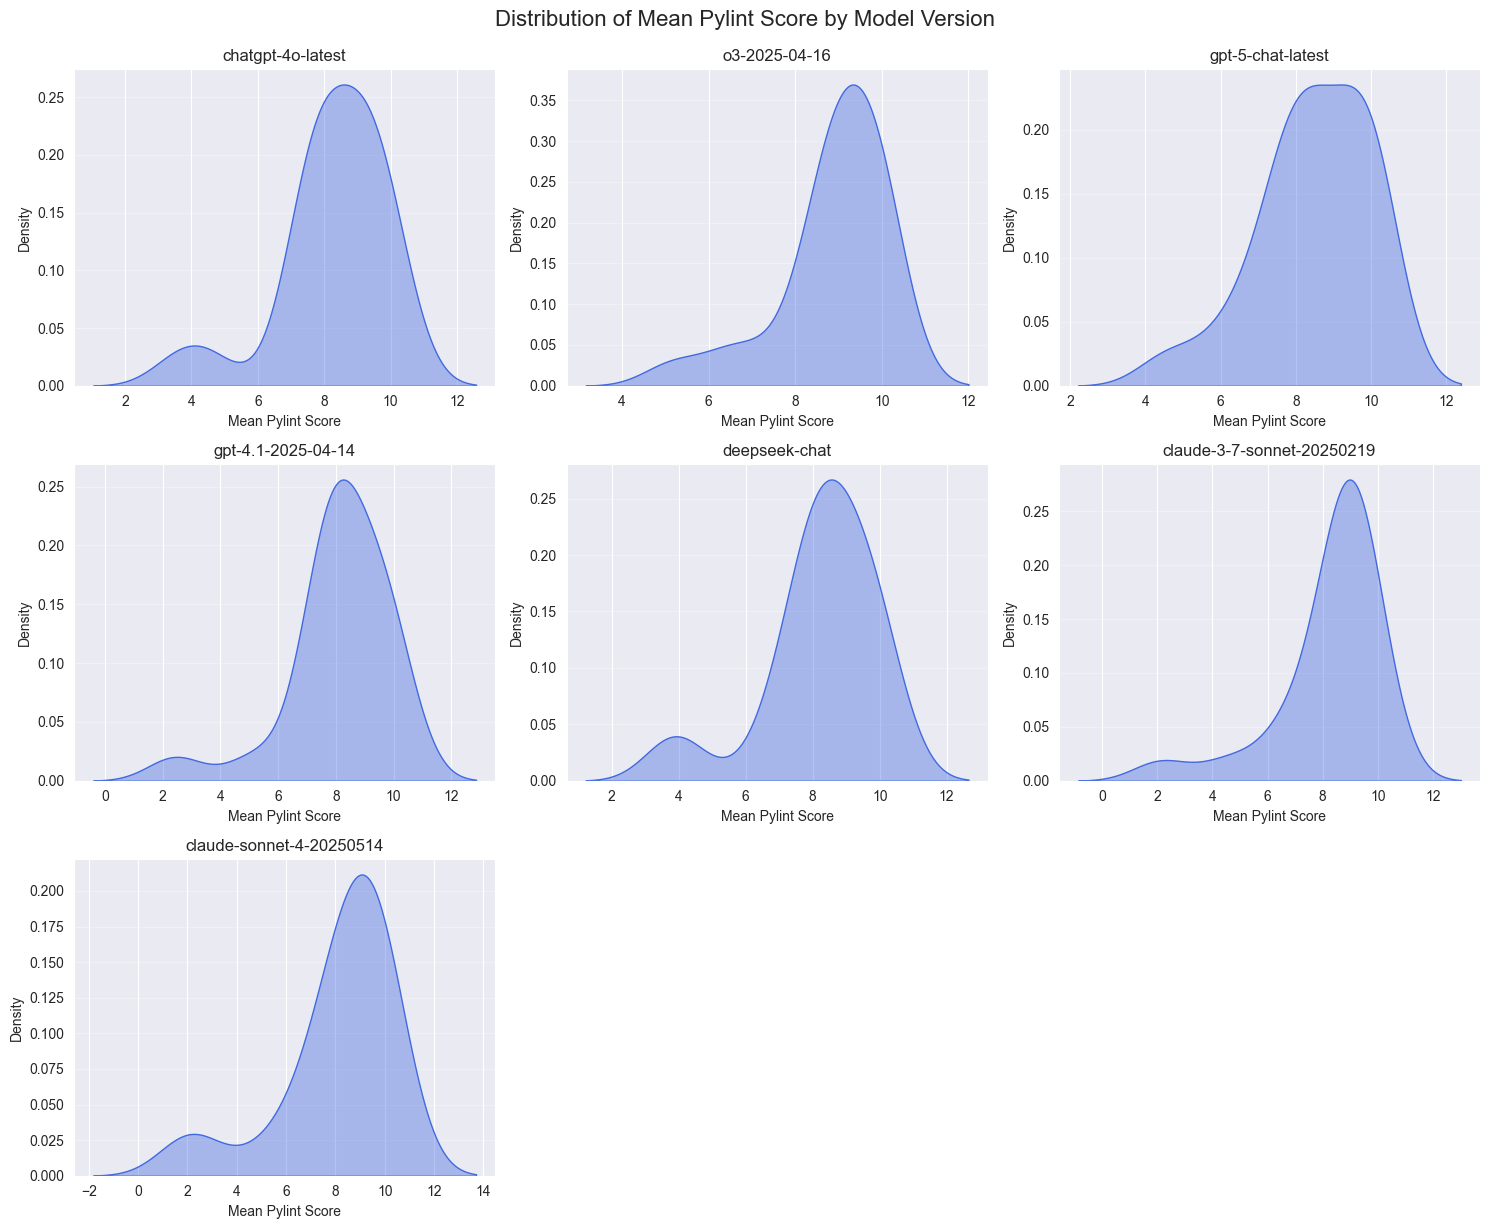

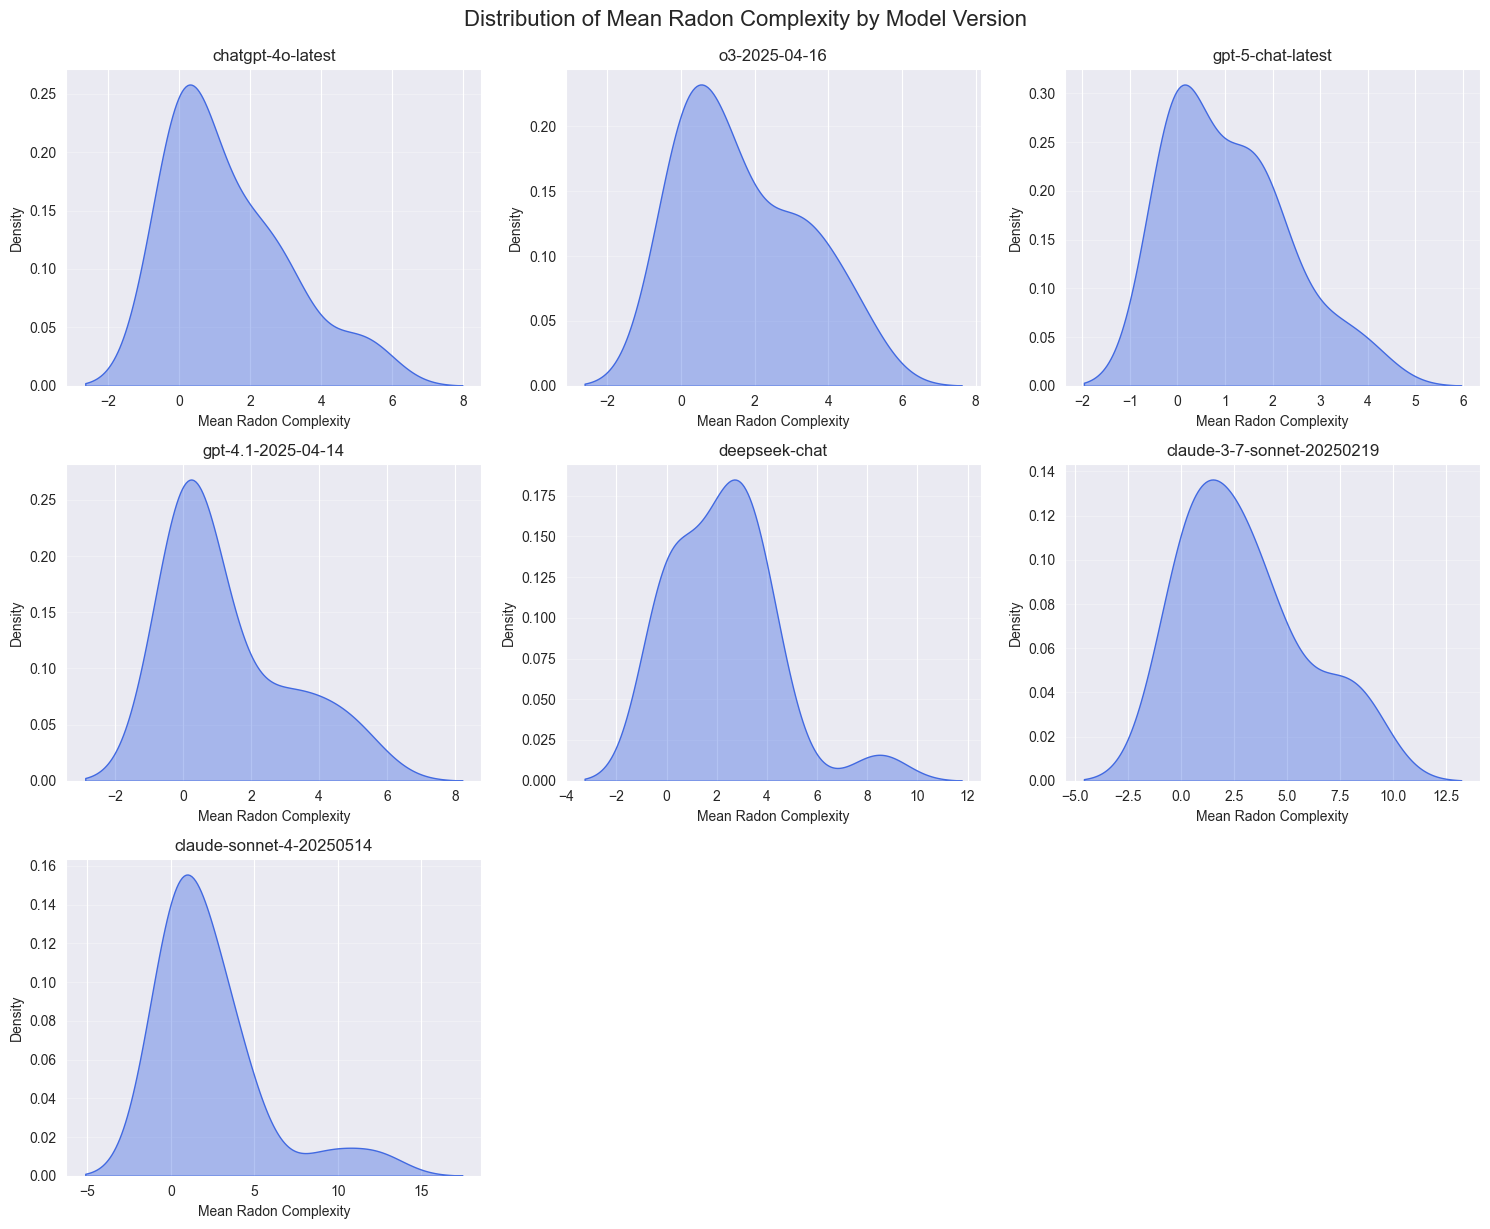

In [7]:
plot_model_distributions(agg_df, models, 'mean_pylint_score', kde=True)
plot_model_distributions(agg_df, models, 'mean_radon_complexity', kde=True)

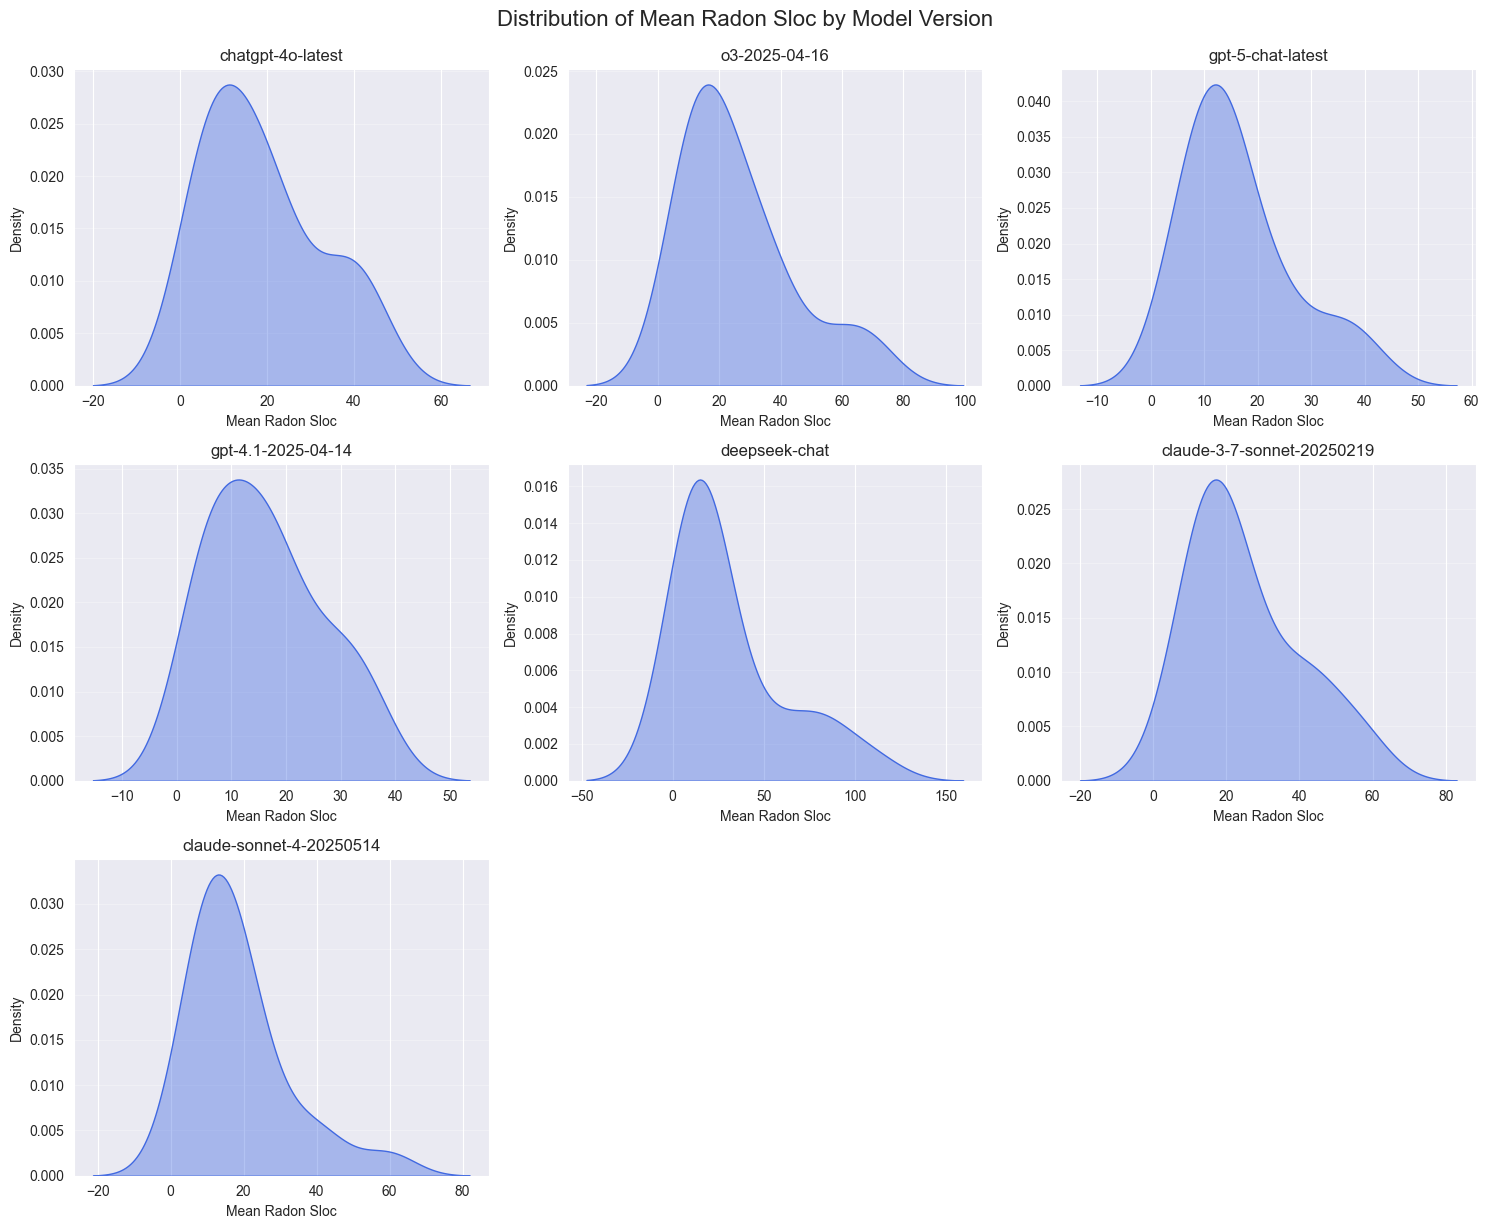

In [8]:
plot_model_distributions(agg_df, models, 'mean_radon_sloc', kde=True)

## Correlate

## Normality test

In [9]:
from scipy.stats import shapiro, normaltest


test_cols = [
             "radon_complexity",
    "radon_maintainability_index",
    "radon_loc",
    "radon_sloc",
    "radon_lloc",
    "radon_comments",
    "pylint_score",
    "validity_score",
    "cleanliness_score",
    "readability_score",
    "structure_score",
    "best_practices_score"]
other = ["maj_objectives_score",
    "maj_communication_score",

    "informational",
    "involved",
    "inv_inf"]

test_cols = ["mean_" + col for col in test_cols] + other


results = []

for model, group in agg_df.groupby("model_version"):
    for col in test_cols:
        data = group[col].dropna()
        if len(data) >= 3:
            stat, p = normaltest(data)
        else:
            stat, p = float('nan'), float('nan')
        results.append({
            "model_version": model,
            "variable": col,
            "dagostino_p": p
        })

results_df = pd.DataFrame(results)
results_df



,model_version,variable,dagostino_p
0,chatgpt-4o-latest,mean_radon_complexity,0.066424
1,chatgpt-4o-latest,mean_radon_maintainability_index,0.085298
2,chatgpt-4o-latest,mean_radon_loc,0.216250
3,chatgpt-4o-latest,mean_radon_sloc,0.260410
4,chatgpt-4o-latest,mean_radon_lloc,0.261881
...,...,...,...
114,o3-2025-04-16,maj_objectives_score,0.690338
115,o3-2025-04-16,maj_communication_score,0.755917
116,o3-2025-04-16,informational,0.291052
117,o3-2025-04-16,involved,0.267688


--> most variables are not normally distributed

In [35]:
import pandas as pd
from scipy.stats import spearmanr
import pingouin as pg
from statsmodels.stats.multitest import multipletests

# Set your column names:
code_quality_cols = [
    "mean_radon_complexity", "mean_radon_maintainability_index", "mean_radon_loc",
    "mean_radon_sloc", "mean_radon_lloc", "mean_radon_comments", "mean_pylint_score",
    "mean_validity_score", "mean_cleanliness_score", "mean_readability_score", "mean_structure_score", "mean_best_practices_score"
]
prompt_marker_cols = [
    "length_message_text_words", "length_conversational_words", "inv_inf", "informational", "involved", "maj_objectives_score", "maj_communication_score"
]

model_corrs = {}

for model, df_sub in agg_df.groupby("model_version"):
    results = []
    for cq in code_quality_cols:
        for pm in prompt_marker_cols:
            x = df_sub[pm]
            y = df_sub[cq]
            mask = x.notna() & y.notna()
            n = mask.sum()
            if n >= 3:
                corr, pval = spearmanr(x[mask], y[mask])
                ci = pg.compute_bootci(
                    x[mask].values,
                    y[mask].values,
                    func='spearman',
                    paired=True,
                    confidence=0.95,
                    n_boot=1000,
                    seed=42
                )
                ci_low, ci_high = ci
            else:
                corr, pval, ci_low, ci_high = (float('nan'), float('nan'), float('nan'), float('nan'))
            results.append({
                "code_quality_metric": cq,
                "prompt_marker": pm,
                "correlation": corr,
                "p_value": pval,
                "ci_low": ci_low,
                "ci_high": ci_high,
                "model": model,
                "n": n,
            })
    # Convert to DataFrame
    df_results = pd.DataFrame(results)
    df_results["ci"] = df_results.apply(lambda row: [row["ci_low"], row["ci_high"]], axis=1)
    df_results = df_results.drop(columns=["ci_low", "ci_high"])


    # Apply Benjamini-Hochberg FDR correction to all non-NaN p-values
    valid_pvalues = df_results["p_value"].notna()
    pvals = df_results.loc[valid_pvalues, "p_value"].values

    # Only correct if there are any valid p-values
    if len(pvals) > 0:
        rejected, pvals_corr, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
        # Insert the FDR-adjusted p-values into correct rows; fill others with NaN
        df_results['p_FDR'] = float('nan')
        df_results.loc[valid_pvalues, 'p_FDR'] = pvals_corr
    else:
        df_results['p_FDR'] = float('nan')

    order = ["code_quality_metric", "prompt_marker", "correlation", "p_value", "p_FDR", "ci", "model"]
    df_results = df_results[order]


    model_corrs[model] = df_results

In [33]:
model_corrs['chatgpt-4o-latest']

,code_quality_metric,prompt_marker,correlation,p_value,p_FDR,ci
0,mean_radon_complexity,length_message_text_words,0.066159,0.764238,0.879397,"[-0.35, 0.47]"
1,mean_radon_complexity,length_conversational_words,0.406501,0.054248,0.207128,"[-0.1, 0.76]"
2,mean_radon_complexity,inv_inf,-0.310217,0.149696,0.370275,"[-0.65, 0.05]"
3,mean_radon_complexity,informational,0.143030,0.515011,0.697757,"[-0.26, 0.57]"
4,mean_radon_complexity,involved,-0.279933,0.195772,0.411121,"[-0.6, 0.12]"
...,...,...,...,...,...,...
79,mean_best_practices_score,inv_inf,0.060217,0.784906,0.890974,"[-0.36, 0.53]"
80,mean_best_practices_score,informational,-0.088291,0.688716,0.857387,"[-0.5, 0.38]"
81,mean_best_practices_score,involved,0.066361,0.763538,0.879397,"[-0.31, 0.47]"
82,mean_best_practices_score,maj_objectives_score,-0.206674,0.344062,0.545305,"[-0.58, 0.25]"


### to latex

In [38]:
def make_latex_table(df):
    model = df['model'].iloc[0]
    cols = ["code_quality_metric", "prompt_marker", "correlation", "p_value", "p_FDR", "ci"]
    labels = ["Metric", "Prompt Marker", "Coeff.", "p", "p corrected", "CI (95%)"]
    df.to_latex(f"{model}_corrs", columns=cols, header=labels, index=False, float_format="%.2f", escape=True, longtable=True)

for model_df in model_corrs.values():
    make_latex_table(model_df)

## Count significant models

In [12]:
import pandas as pd

tmp = []

# Loop through each model and its DataFrame
for model_name, df in model_corrs.items():
    # Find rows with significant p-value
    sig_rows = df[df["p_FDR"] < 0.05].copy()
    # Add the model name so we can track it
    sig_rows["model"] = model_name
    # Add direction column based on the sign of the correlation coefficient
    sig_rows["direction"] = sig_rows["correlation"].apply(
        lambda x: "positive" if x > 0 else ("negative" if x < 0 else "zero")
    )
    tmp.append(sig_rows)

# Concatenate all significant rows across all models
tmp_df = pd.concat(tmp, ignore_index=True)

# Create the 'correlation' column (e.g., "readability_score x can_you_question")
tmp_df["correlation"] = (
        tmp_df["code_quality_metric"].astype(str)
        + " x "
        + tmp_df["prompt_marker"].astype(str)
)

# Group by correlation, gather list of model names and correlation directions, and count
result = (
    tmp_df.groupby("correlation")
    .agg(
        models_with_significance=('model', list),     # List models where significant
        count_significant=('model', 'nunique'),       # How many models significant
        directions=('direction', list)                # List of directions per significant
    )
    .reset_index()
    .sort_values("count_significant", ascending=False)
)
result.to_latex("code_quality_correlations_summary.tex", index=False, columns=["correlation", "direction", "models_with_significance"])
result


,correlation,models_with_significance,count_significant,directions
0,mean_radon_comments x length_conversational_words,"[chatgpt-4o-latest, claude-3-7-sonnet-20250219...",5,"[positive, positive, positive, positive, posit..."
2,mean_radon_loc x length_conversational_words,"[chatgpt-4o-latest, gpt-4.1-2025-04-14, gpt-5-...",3,"[positive, positive, positive]"
1,mean_radon_lloc x length_conversational_words,"[chatgpt-4o-latest, gpt-4.1-2025-04-14]",2,"[positive, positive]"
5,mean_radon_maintainability_index x length_conv...,"[chatgpt-4o-latest, gpt-4.1-2025-04-14]",2,"[negative, negative]"
6,mean_radon_sloc x length_conversational_words,"[chatgpt-4o-latest, gpt-4.1-2025-04-14]",2,"[positive, positive]"
3,mean_radon_loc x length_message_text_words,[gpt-4.1-2025-04-14],1,[positive]
4,mean_radon_maintainability_index x inv_inf,[gpt-5-chat-latest],1,[positive]


## Visualize an example

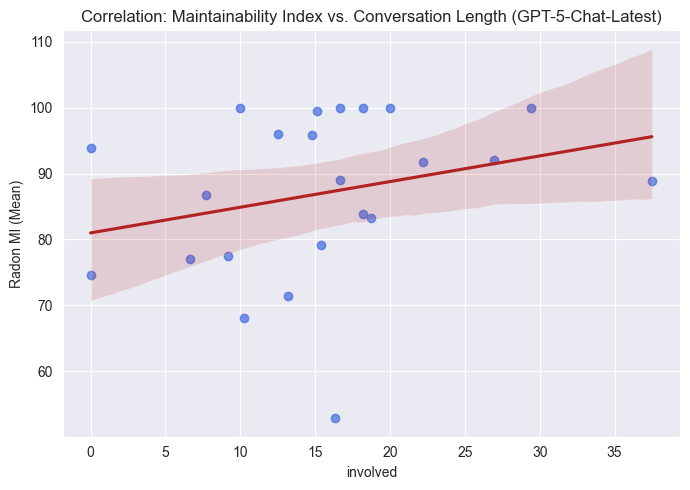

In [13]:
gpt5_df = agg_df[agg_df['model_version'] == 'o3-2025-04-16']
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
sns.regplot(
    data=gpt5_df,
    x="involved",
    y="mean_radon_maintainability_index",
    scatter_kws={'alpha': 0.7, 'color': 'royalblue'},
    line_kws={'color': 'firebrick'}
)
plt.xlabel("involved")
plt.ylabel("Radon MI (Mean)")
plt.title("Correlation: Maintainability Index vs. Conversation Length (GPT-5-Chat-Latest)")
plt.tight_layout()
plt.show()


## Average Correlations across models

In [14]:
import pandas as pd
import numpy as np
import pingouin as pg

# model_corrs_dict: dictionary such that
#   key: model name/version (string)
#   value: dataframe with columns ['code_quality_metric', 'prompt_marker', 'correlation', 'p_value']

# 1. Stack all model DataFrames, tagging with model name/version
all_corrs = []
for model, df in model_corrs.items():
    temp = df.copy()
    temp['model'] = model
    all_corrs.append(temp)
all_corrs_df = pd.concat(all_corrs, axis=0, ignore_index=True)

# 2. Group and aggregate across models
def agg_ci(group):
    corrs = group['correlation'].values
    mean_corr = np.mean(corrs)
    std_corr = np.std(corrs, ddof=1)
    boot = pg.compute_bootci(corrs, func='mean', n_boot=10000, seed=42)
    ci_low = np.percentile(boot, 2.5)
    ci_high = np.percentile(boot, 97.5)
    return pd.Series({
        'mean': mean_corr,
        'std': std_corr,
        'ci_low': ci_low,
        'ci_high': ci_high
    })

def agg_ci_fisher_fixed_effect(group):
    # group must contain columns: 'correlation' and 'n' (sample size for each r)
    r = group['correlation'].to_numpy(dtype=float)
    n = group['n'].to_numpy(dtype=float)

    # Drop NaNs and invalid ns
    mask = np.isfinite(r) & np.isfinite(n) & (n > 3)
    r = r[mask]
    n = n[mask]
    k = r.size
    if k == 0:
        return pd.Series({'mean': np.nan, 'se': np.nan, 'ci_low': np.nan, 'ci_high': np.nan})

    # Clip to avoid ±inf
    eps = 1e-6
    r = np.clip(r, -1 + eps, 1 - eps)

    z = np.arctanh(r)
    w = n - 3.0

    z_bar = np.sum(w * z) / np.sum(w)
    se_z = 1.0 / np.sqrt(np.sum(w))

    # 95% CI on z
    z_lo = z_bar - 1.96 * se_z
    z_hi = z_bar + 1.96 * se_z

    # Back-transform
    r_bar = np.tanh(z_bar)
    ci_lo = np.tanh(z_lo)
    ci_hi = np.tanh(z_hi)

    # Delta-method SE on r scale (optional)
    se_r = (1.0 - r_bar**2) * se_z

    return pd.Series({'mean': r_bar, 'se': se_r, 'ci_low': ci_lo, 'ci_high': ci_hi})


agg_corr_df = (
    all_corrs_df
    .groupby(['code_quality_metric', 'prompt_marker'])
    .apply(agg_ci_fisher_fixed_effect)
    .reset_index()
)[['code_quality_metric', 'prompt_marker', 'mean', 'se', 'ci_low', 'ci_high']]



quality_metrics = [
    "mean_radon_complexity",
    "mean_radon_maintainability_index",
    "mean_radon_loc",
    "mean_radon_sloc",
    "mean_radon_lloc",
    "mean_radon_comments",
    "mean_pylint_score",
]

# First DataFrame: only those with code_quality_metric in the list
df_metrics = agg_corr_df[agg_corr_df["code_quality_metric"].isin(quality_metrics)].copy()

# Second DataFrame: all other rows
df_other = agg_corr_df[~agg_corr_df["code_quality_metric"].isin(quality_metrics)].copy()

# Python
import pandas as pd


VAR_X = "prompt_marker"   # e.g., the prompt variable column
VAR_Y = "code_quality_metric"   # e.g., the code characteristic column
CORR = "correlation"     # correlation value column name

def to_long_corr(df):
    """
    Ensure df has columns [VAR_X, VAR_Y, CORR].
    If df is a matrix (index=vars_x, columns=vars_y, values=corr),
    convert it to long format.
    """
    cols = set(df.columns)
    if {VAR_X, VAR_Y, CORR}.issubset(cols):
        return df[[VAR_X, VAR_Y, CORR]].copy()

    long = df.stack().reset_index()
    long.columns = [VAR_X, VAR_Y, CORR]
    return long

# 1) Concatenate all models' correlations into one long DataFrame
all_corrs = []
for model_name, corr_df in model_corrs.items():
    long_df = to_long_corr(corr_df)
    long_df["model"] = model_name
    # keep only finite correlations
    long_df = long_df[pd.to_numeric(long_df[CORR], errors="coerce").notna()]
    all_corrs.append(long_df)

all_corrs = pd.concat(all_corrs, ignore_index=True)

# 2) Count positive/negative (and optionally zero) correlations per pair
pair_counts = (
    all_corrs
    .groupby([VAR_X, VAR_Y], as_index=False)
    .agg(
        n_models=("model", "nunique"),
        n_pos=(CORR, lambda s: (s > 0).sum()),
        n_neg=(CORR, lambda s: (s < 0).sum()),
        n_zero=(CORR, lambda s: (s == 0).sum())  # optional; drop if not needed
    )
)

# 3) Merge into your existing df_metrics
# Make sure df_metrics has the same pair keys (VAR_X, VAR_Y)
df_metrics = df_metrics.merge(
    pair_counts[[VAR_X, VAR_Y, "n_pos", "n_neg"]],  # add "n_zero" if you want it
    on=[VAR_X, VAR_Y],
    how="left"
)
df_other = df_other.merge(
    pair_counts[[VAR_X, VAR_Y, "n_pos", "n_neg"]],  # add "n_zero" if you want it
    on=[VAR_X, VAR_Y],
    how="left"
)

df_metrics



/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_42052/3938007135.py:73: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_ci_fisher_fixed_effect)


,code_quality_metric,prompt_marker,mean,se,ci_low,ci_high,n_pos,n_neg
0,mean_pylint_score,informational,-0.140240,0.084374,-0.300310,0.027512,1,6
1,mean_pylint_score,inv_inf,0.101959,0.085172,-0.066279,0.264559,5,2
2,mean_pylint_score,involved,-0.036772,0.085950,-0.202635,0.131142,3,4
3,mean_pylint_score,length_conversational_words,-0.088590,0.085391,-0.251968,0.079697,1,6
4,mean_pylint_score,length_message_text_words,-0.392755,0.072790,-0.525381,-0.241498,0,7
5,mean_pylint_score,maj_communication_score,-0.057063,0.085786,-0.222053,0.111105,3,4
6,mean_pylint_score,maj_objectives_score,-0.157576,0.083929,-0.316353,0.009790,1,6
7,mean_radon_comments,informational,0.367621,0.073356,0.215970,0.501954,7,0
8,mean_radon_comments,inv_inf,-0.177425,0.082149,-0.332439,-0.013077,0,7
9,mean_radon_comments,involved,-0.162515,0.082579,-0.318713,0.002276,0,7


## Heatmaps

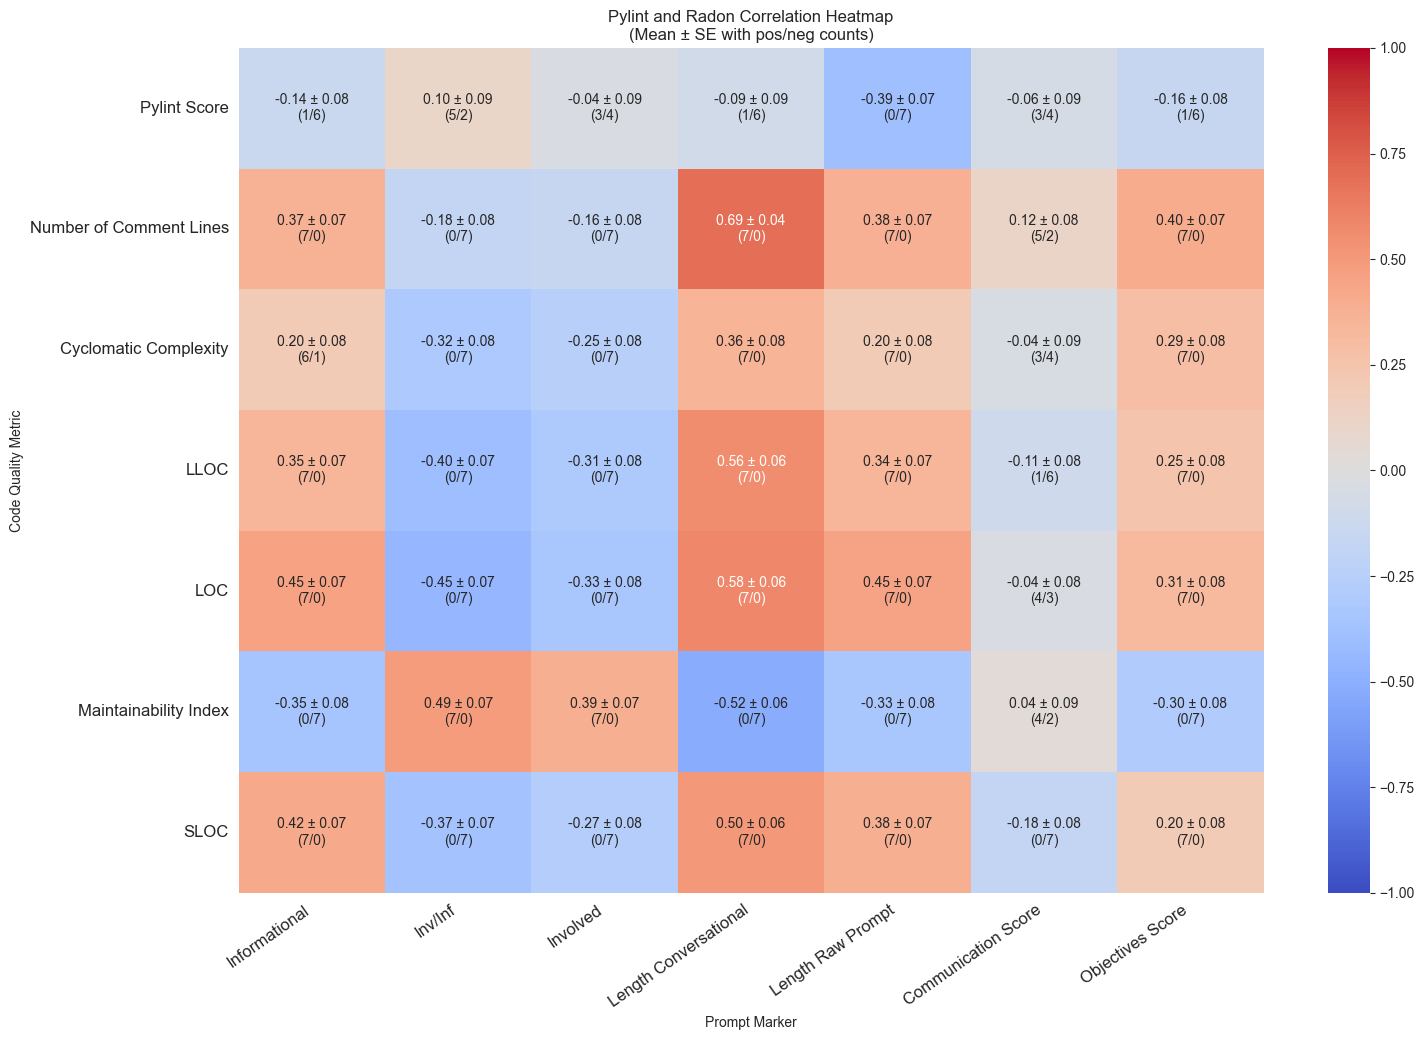

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot for mean and SE
heatmap_mean = df_metrics.pivot(index='code_quality_metric', columns='prompt_marker', values='mean')
heatmap_se = df_metrics.pivot(index='code_quality_metric', columns='prompt_marker', values='se')

# Pick the columns that hold the positive/negative counts
pos_col = 'n_pos'
neg_col = 'n_neg'


# Pivot for pos/neg counts
heatmap_pos = df_metrics.pivot(index='code_quality_metric', columns='prompt_marker', values=pos_col)
heatmap_neg = df_metrics.pivot(index='code_quality_metric', columns='prompt_marker', values=neg_col)

# Build annotation text with mean ± SE and (pos/neg)
annot = heatmap_mean.copy().astype(str)
for i in heatmap_mean.index:
    for j in heatmap_mean.columns:
        m = heatmap_mean.loc[i, j]
        s = heatmap_se.loc[i, j]
        p = heatmap_pos.loc[i, j]
        n = heatmap_neg.loc[i, j]
        if pd.isna(m) or pd.isna(s) or pd.isna(p) or pd.isna(n):
            annot.loc[i, j] = ""
        else:
            annot.loc[i, j] = f"{m:.2f} ± {s:.2f}\n({int(p)}/{int(n)})"

plt.figure(figsize=(len(heatmap_mean.columns)*2.2, len(heatmap_mean.index)*1.5))
ax = sns.heatmap(
    heatmap_mean,
    annot=annot,
    fmt='',
    cmap="coolwarm",
    vmin=-1, vmax=1,
    annot_kws={"size": 10}
)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

x_rotation = 35              # rotate x tick labels
y_rotation = 0               # rotate y tick labels
x_ha = "right"               # horizontal alignment for x labels: 'left'|'center'|'right'
y_ha = "right"


x_labels = ["Informational", "Inv/Inf", "Involved", "Length Conversational", "Length Raw Prompt", "Communication Score", "Objectives Score"]
y_labels = ["Pylint Score", "Number of Comment Lines", "Cyclomatic Complexity", "LLOC", "LOC", "Maintainability Index", "SLOC"]

ax.set_xticklabels(x_labels, rotation=x_rotation, ha=x_ha)
ax.set_yticklabels(y_labels, rotation=y_rotation, ha=y_ha)


plt.title("Pylint and Radon Correlation Heatmap\n(Mean ± SE with pos/neg counts)")
plt.ylabel("Code Quality Metric")
plt.xlabel("Prompt Marker")
plt.tight_layout()
plt.show()

In [16]:
df_other

,code_quality_metric,prompt_marker,mean,se,ci_low,ci_high,n_pos,n_neg
0,mean_best_practices_score,informational,-0.054611,0.084566,-0.217386,0.111119,2,5
1,mean_best_practices_score,inv_inf,0.059601,0.084518,-0.106172,0.222150,6,1
2,mean_best_practices_score,involved,0.017127,0.084794,-0.148021,0.181345,3,4
3,mean_best_practices_score,length_conversational_words,-0.231375,0.080278,-0.381562,-0.069286,0,7
4,mean_best_practices_score,length_message_text_words,-0.176767,0.082169,-0.331834,-0.012398,0,7
5,mean_best_practices_score,maj_communication_score,-0.006619,0.084815,-0.171163,0.158283,2,5
6,mean_best_practices_score,maj_objectives_score,-0.155743,0.082762,-0.312457,0.009224,0,7
7,mean_cleanliness_score,informational,-0.115455,0.083688,-0.274956,0.050231,1,6
8,mean_cleanliness_score,inv_inf,0.180517,0.082055,0.016271,0.335277,6,1
9,mean_cleanliness_score,involved,0.143324,0.083077,-0.021924,0.300948,7,0


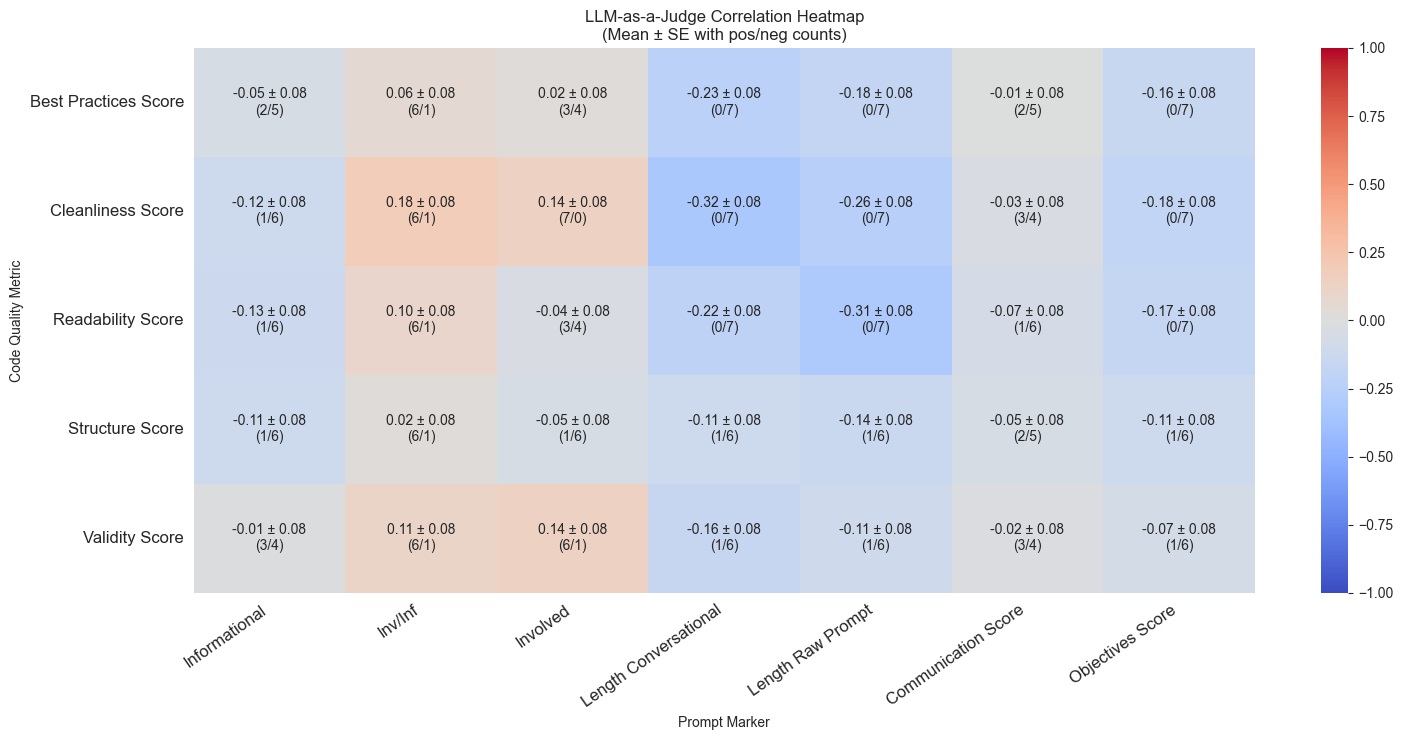

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Pivot for each relevant value
heatmap_mean = df_other.pivot(index='code_quality_metric', columns='prompt_marker', values='mean')
heatmap_se = df_other.pivot(index='code_quality_metric', columns='prompt_marker', values='se')
# Pick the columns that hold the positive/negative counts
pos_col = 'n_pos'
neg_col = 'n_neg'
# Pivot for pos/neg counts
heatmap_pos = df_other.pivot(index='code_quality_metric', columns='prompt_marker', values=pos_col)
heatmap_neg = df_other.pivot(index='code_quality_metric', columns='prompt_marker', values=neg_col)

# Build annotation text with mean ± SE and (pos/neg)
annot = heatmap_mean.copy().astype(str)
for i in heatmap_mean.index:
    for j in heatmap_mean.columns:
        m = heatmap_mean.loc[i, j]
        s = heatmap_se.loc[i, j]
        p = heatmap_pos.loc[i, j]
        n = heatmap_neg.loc[i, j]
        if pd.isna(m) or pd.isna(s) or pd.isna(p) or pd.isna(n):
            annot.loc[i, j] = ""
        else:
            annot.loc[i, j] = f"{m:.2f} ± {s:.2f}\n({int(p)}/{int(n)})"


plt.figure(figsize=(len(heatmap_mean.columns)*2.2, len(heatmap_mean.index)*1.5))
ax = sns.heatmap(
    heatmap_mean,
    annot=annot,
    fmt='',
    cmap="coolwarm",
    vmin=-1, vmax=1,
    annot_kws={"size": 10}
)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

x_rotation = 35              # rotate x tick labels
y_rotation = 0               # rotate y tick labels
x_ha = "right"               # horizontal alignment for x labels: 'left'|'center'|'right'
y_ha = "right"


x_labels = ["Informational", "Inv/Inf", "Involved", "Length Conversational", "Length Raw Prompt", "Communication Score", "Objectives Score"]
y_labels = ["Best Practices Score", "Cleanliness Score", "Readability Score", "Structure Score", "Validity Score"]

ax.set_xticklabels(x_labels, rotation=x_rotation, ha=x_ha)
ax.set_yticklabels(y_labels, rotation=y_rotation, ha=y_ha)

plt.title("LLM-as-a-Judge Correlation Heatmap\n(Mean ± SE with pos/neg counts)")
plt.ylabel("Code Quality Metric")
plt.xlabel("Prompt Marker")
plt.tight_layout()
plt.show()

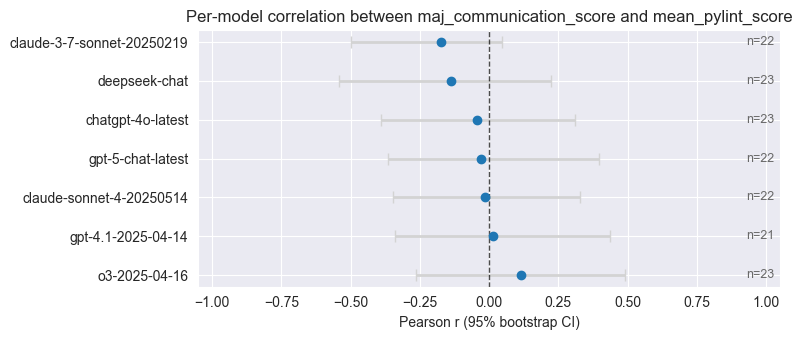

,model_version,n,r,ci_low,ci_high
0,o3-2025-04-16,23,0.113605,-0.263007,0.488805
1,gpt-4.1-2025-04-14,21,0.013694,-0.338986,0.437929
2,claude-sonnet-4-20250514,22,-0.013850,-0.348305,0.327169
3,gpt-5-chat-latest,22,-0.030005,-0.365165,0.395370
4,chatgpt-4o-latest,23,-0.044535,-0.391613,0.310868
5,deepseek-chat,23,-0.139272,-0.540379,0.222923
6,claude-3-7-sonnet-20250219,22,-0.174518,-0.499390,0.047323


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Choose the effect and outcome here
effect_var = "maj_communication_score"  # or "maj_objectives_score"
outcome_var = "mean_pylint_score"  # e.g., "mean_radon_maintainability_index", etc.

# Basic validations
required_cols = {effect_var, outcome_var, "model_version"}
missing = required_cols - set(agg_df.columns)
if missing:
    raise KeyError(f"Required columns are missing from agg_df: {missing}")


def bootstrap_corr(x: np.ndarray, y: np.ndarray, n_boot: int = 5000, seed: int = 12345):
    """Nonparametric bootstrap 95% CI for Pearson correlation."""
    rng = np.random.default_rng(seed)
    n = len(x)
    if n < 3:
        return np.nan, np.nan
    idx = np.arange(n)
    boots = []
    for _ in range(n_boot):
        bidx = rng.choice(idx, size=n, replace=True)
        xb, yb = x[bidx], y[bidx]
        # Guard against zero-variance resamples
        if np.std(xb) == 0 or np.std(yb) == 0:
            continue
        r = np.corrcoef(xb, yb)[0, 1]
        if np.isfinite(r):
            boots.append(r)
    if len(boots) == 0:
        return np.nan, np.nan
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return float(lo), float(hi)


def per_model_correlation(df: pd.DataFrame, x_col: str, y_col: str) -> pd.DataFrame:
    """Compute per-model Pearson r and 95% bootstrap CI."""
    rows = []
    for model, g in df.groupby("model_version", dropna=True):
        # Drop rows with missing values in either column
        gi = g[[x_col, y_col]].dropna()
        n = len(gi)
        if n < 3:
            rows.append({
                "model_version": model,
                "n": n,
                "r": np.nan,
                "ci_low": np.nan,
                "ci_high": np.nan
            })
            continue
        x = gi[x_col].to_numpy(dtype=float)
        y = gi[y_col].to_numpy(dtype=float)

        r = float(np.corrcoef(x, y)[0, 1])
        ci_low, ci_high = bootstrap_corr(x, y, n_boot=5000, seed=12345)
        rows.append({
            "model_version": model,
            "n": n,
            "r": r,
            "ci_low": ci_low,
            "ci_high": ci_high
        })
    out = pd.DataFrame(rows).dropna(subset=["model_version"])
    # Sort by effect size for a cleaner forest plot
    out = out.sort_values(by="r", ascending=False, na_position="last").reset_index(drop=True)
    return out


def plot_forest(df_stats: pd.DataFrame, x_label: str, title: str):
    """Render a forest plot given per-model stats with columns: model_version, r, ci_low, ci_high, n."""
    if df_stats.empty:
        raise ValueError("No data available to plot. Check your filters and column choices.")

    # Figure size scales with number of models
    h = max(2.0, 0.5 * len(df_stats))  # 0.5 inch per model
    fig, ax = plt.subplots(figsize=(8, h))

    y_pos = np.arange(len(df_stats))
    # Horizontal error bars for CI
    ax.errorbar(
        x=df_stats["r"],
        y=y_pos,
        xerr=[df_stats["r"] - df_stats["ci_low"], df_stats["ci_high"] - df_stats["r"]],
        fmt="o",
        color="tab:blue",
        ecolor="lightgray",
        elinewidth=2,
        capsize=4
    )
    # Reference line at 0 correlation
    ax.axvline(0.0, color="black", linewidth=1, linestyle="--", alpha=0.7)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_stats["model_version"])
    ax.set_xlabel(x_label)
    ax.set_title(title)

    # Constrain x-limits to [-1, 1] for correlations (with small padding)
    xmin = np.nanmin([np.nanmin(df_stats["ci_low"]), -1.0])
    xmax = np.nanmax([np.nanmax(df_stats["ci_high"]), 1.0])
    ax.set_xlim(max(-1.05, xmin - 0.05), min(1.05, xmax + 0.05))

    # Annotate sample sizes
    for i, (r, n) in enumerate(zip(df_stats["r"], df_stats["n"])):
        ax.text(
            x=(ax.get_xlim()[1] - 0.02),
            y=i,
            s=f"n={n}",
            va="center",
            ha="right",
            fontsize=9,
            color="dimgray"
        )

    plt.tight_layout()
    plt.show()


# Prepare and plot
stats_df = per_model_correlation(agg_df, effect_var, outcome_var)
plot_title = f"Per-model correlation between {effect_var} and {outcome_var}"
x_axis_label = "Pearson r (95% bootstrap CI)"
plot_forest(stats_df, x_axis_label, plot_title)

stats_df